In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir "/content/salam"

!cp "/content/drive/MyDrive/cell_morphology/roi3/Substac_225_325roi_3_210419_S01_without_tumor_cells_and_without_edges_yellow.tif" "/content/salam"
!cp "/content/drive/MyDrive/cell_morphology/roi3/class2_322.tif" "/content/salam"

In [3]:
!mkdir '/content/salam/images'
!mkdir '/content/salam/masks'

In [4]:

from PIL import Image, ImageSequence

im = Image.open("/content/salam/Substac_225_325roi_3_210419_S01_without_tumor_cells_and_without_edges_yellow.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salam/images/Page%d.png" % i)

In [6]:
from PIL import ImageSequence
im = Image.open("/content/salam/class2_322.tif")
for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salam/masks/Page%d.png" % i)

In [7]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
image_data = []
images_path = sorted(os.listdir('/content/salam/images'))
for image_name in images_path:
        image = cv2.imread('/content/salam/images/' + image_name, 0)
        image = cv2.resize(image, dsize=(768,512), interpolation=cv2.INTER_AREA)
        image_data.append(np.array(image))
        
        
mask_data = []
mask_path = sorted(os.listdir('/content/salam/masks'))
for mask_name in mask_path:
        mask = cv2.imread('/content/salam/masks/' + mask_name, 0)
        mask = cv2.resize(mask, dsize=(768,512), interpolation=cv2.INTER_AREA)
        mask_data.append(np.array(mask))
        
        
image_data = np.expand_dims(np.array(image_data),3) / 255
mask_data = np.expand_dims(np.array(mask_data),3) / 255

In [8]:
print(image_data.shape, mask_data.shape)

(101, 512, 768, 1) (101, 512, 768, 1)


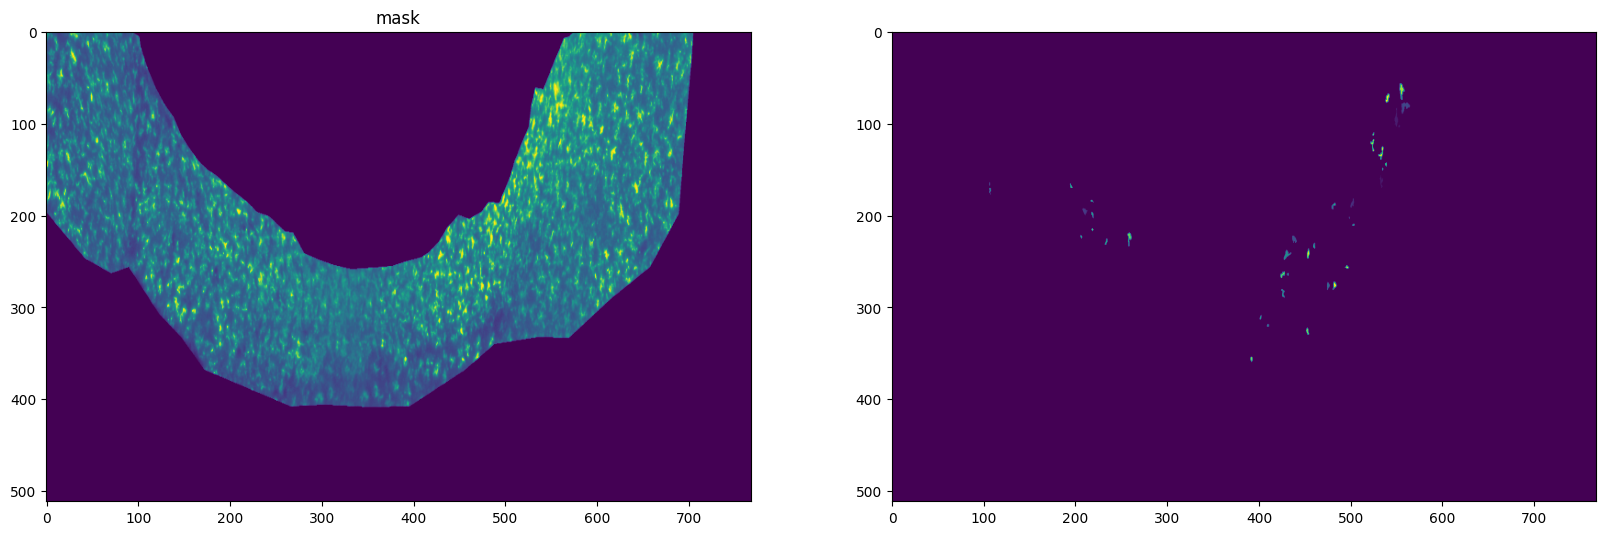

In [10]:

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(np.squeeze(image_data[88]))
ax[0].set_title('image')
ax[1].imshow(np.squeeze(mask_data[88]))
ax[0].set_title('mask')
fig.show()

In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

#U-net model

s = Input((image_data.shape[1], image_data.shape[2], image_data.shape[3]))

#Contraction path
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.3)(c2)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.4)(c3)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

#Expansive path 
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = Dropout(0.4)(c4)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

u5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

model = Model(inputs=[s], outputs=[outputs])
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 768, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 768, 8)  80          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512, 768, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 768, 8)  584         ['dropout[0][0]']            

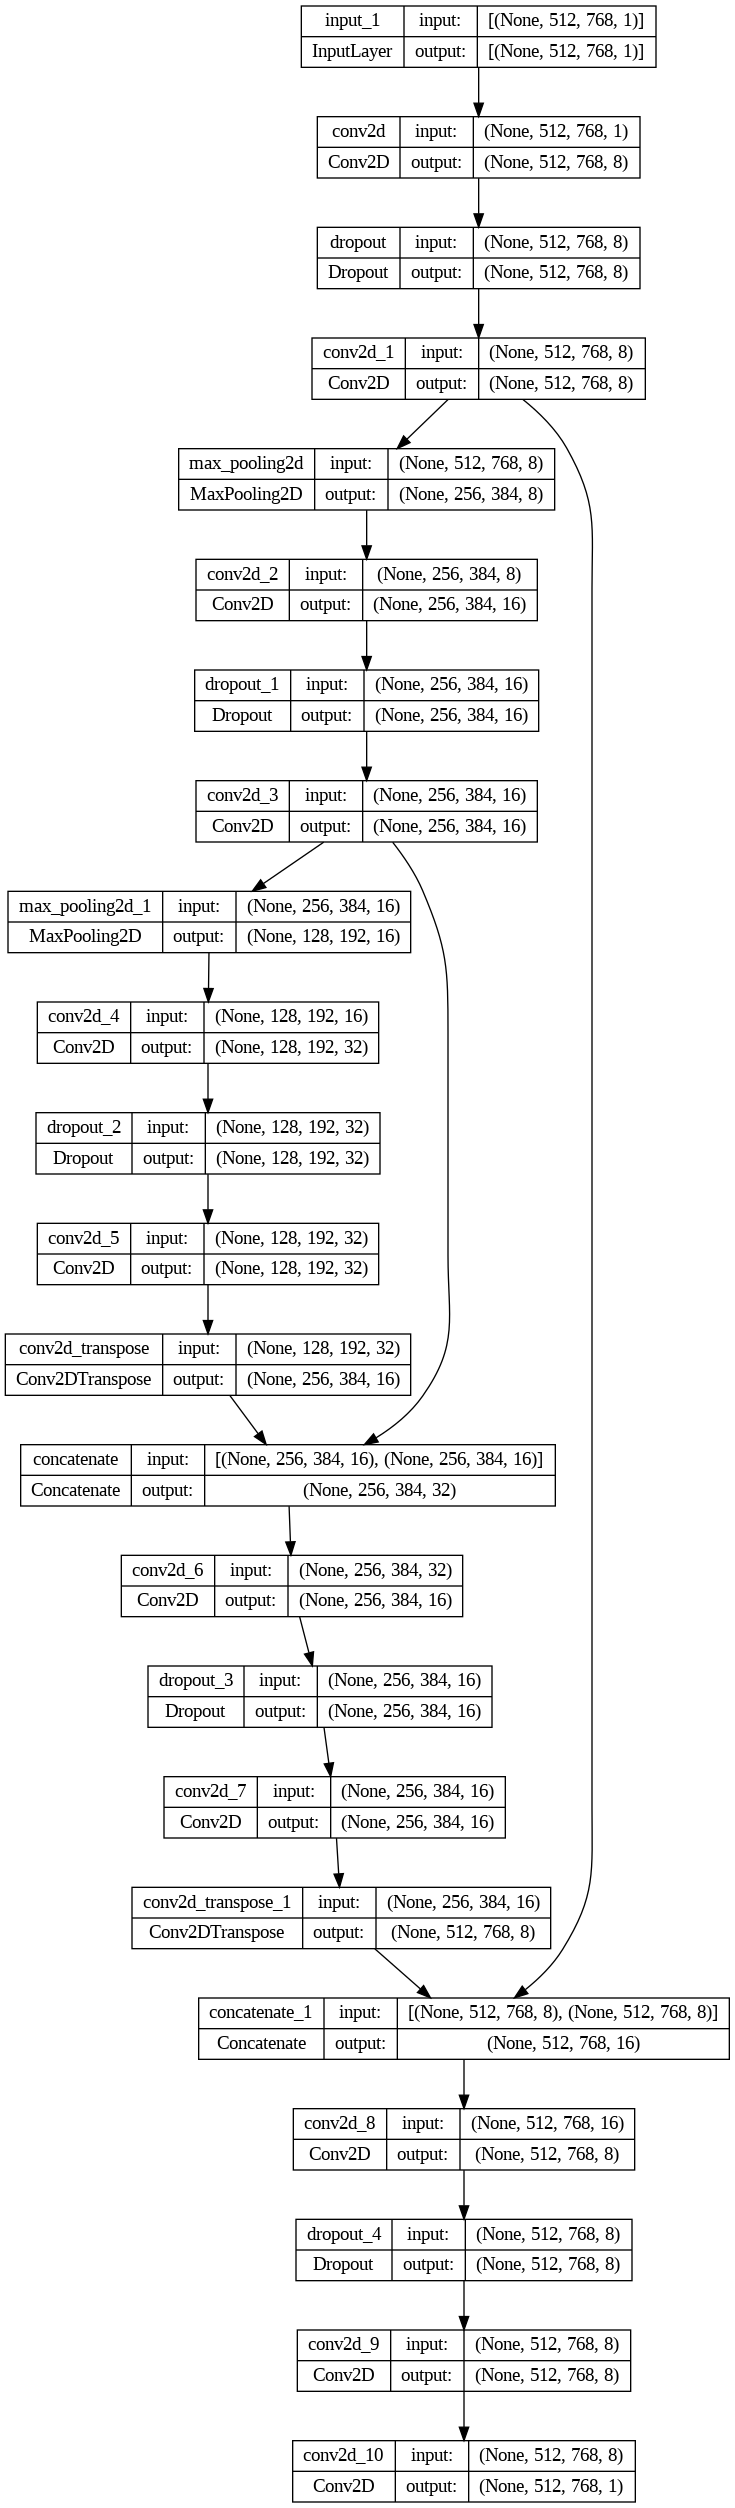

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, mask_data, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('train data size:', X_train.shape[0], '\n')
print('validation data size:', X_val.shape[0], '\n')
print('test data size:', X_test.shape[0])

train data size: 81 

validation data size: 9 

test data size: 11


In [22]:
history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 16,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    epochs = 100)

Epoch 1/100
6/6 [==============================] - 3s 452ms/step - loss: 0.0041 - accuracy: 0.9967 - val_loss: 0.0047 - val_accuracy: 0.9969
Epoch 2/100
6/6 [==============================] - 3s 452ms/step - loss: 0.0041 - accuracy: 0.9967 - val_loss: 0.0050 - val_accuracy: 0.9969
Epoch 3/100
6/6 [==============================] - 3s 449ms/step - loss: 0.0040 - accuracy: 0.9967 - val_loss: 0.0048 - val_accuracy: 0.9969
Epoch 4/100
6/6 [==============================] - 3s 448ms/step - loss: 0.0040 - accuracy: 0.9967 - val_loss: 0.0053 - val_accuracy: 0.9969
Epoch 5/100
6/6 [==============================] - 3s 454ms/step - loss: 0.0040 - accuracy: 0.9967 - val_loss: 0.0049 - val_accuracy: 0.9969
Epoch 6/100
6/6 [==============================] - 3s 458ms/step - loss: 0.0040 - accuracy: 0.9967 - val_loss: 0.0048 - val_accuracy: 0.9969
Epoch 7/100
6/6 [==============================] - 3s 464ms/step - loss: 0.0039 - accuracy: 0.9967 - val_loss: 0.0044 - val_accuracy: 0.9969
Epoch 8/100
6

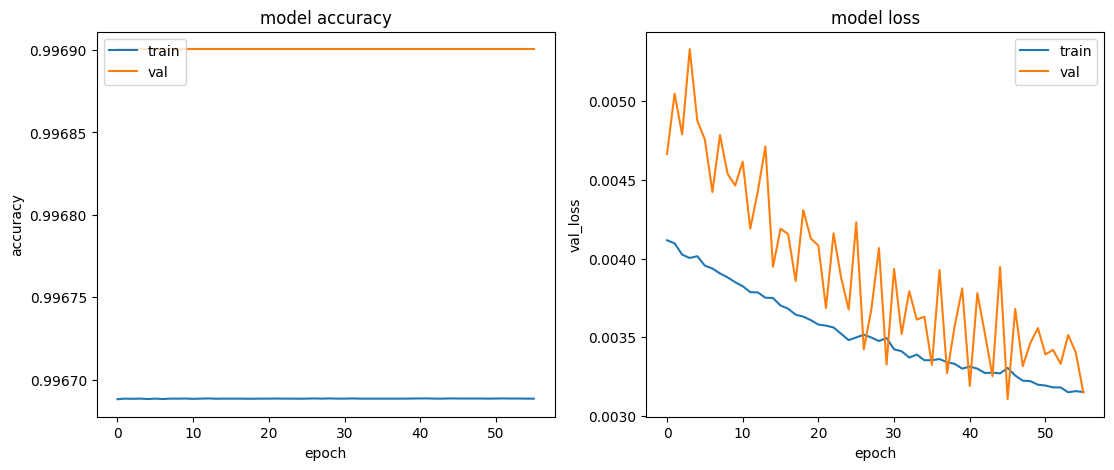

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()
     

1/1 [==============================] - 0s 20ms/step


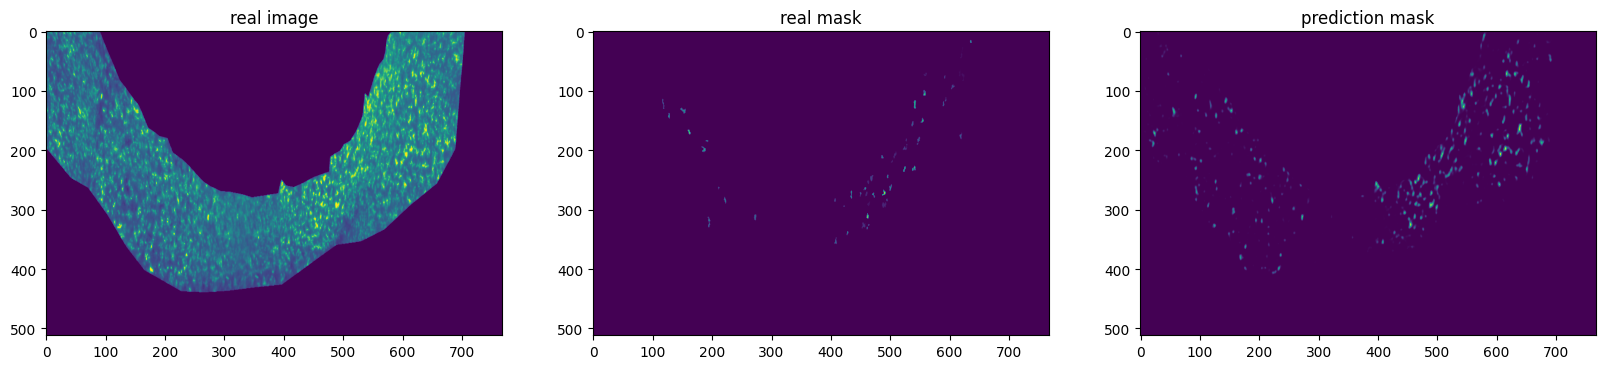

In [24]:

rndm_img = np.random.randint(0,len(X_test))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(np.squeeze(X_test[rndm_img]))
ax[0].set_title('real image')

ax[1].imshow(np.squeeze(y_test[rndm_img]))
ax[1].set_title('real mask')

test_img = np.expand_dims(X_test[rndm_img], axis=0)
rslt = model.predict(test_img)[0]
ax[2].imshow(np.squeeze(rslt))
ax[2].set_title('prediction mask')

fig.show()